In [1]:
import io
import re
import matplotlib.pyplot as plt
import string
import numpy as np
import pandas as pd
from utils import *

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers.experimental import preprocessing

In [29]:
# iterate through zip file of occ reports to construct a dataframe (may take a while)

#occ_df = read_word_doc_zip_as_df('occ-report-docs/occ-reports.zip')

In [30]:
#occ_df = occ_df[["Time", "Log", "BPD"]]
#occ_df['BPD'] = occ_df['BPD'].apply(lambda x: str(x).strip())

In [31]:
#csv = occ_df.to_csv('csv/occ-reports.csv', index=False)

In [32]:
#csv_to_dataset(csv_path, batch_size, label, num_epochs)

In [2]:
occ_df = pd.read_csv('csv/nadav-labeled.csv')
occ_df = occ_df[["Log", "Cat"]]

# first 100 rows are labeled
labeled_df = occ_df.iloc[:100,:]
unlabeled_df = occ_df.iloc[101:,:]

labeled_df = labeled_df[labeled_df.Cat.apply(lambda x: x.isnumeric())]
labeled_df['Cat'] = labeled_df['Cat'].apply(lambda x: int(x))
labeled_df.head(5)

,Log,Cat
0,"T385 released, 5 minutes late.",0
1,CAR COUNT\nA’s: 51 B’s: 329 C’s: 172 ...,0
2,Daily SCRAM / Spare Train Report: OCY: T337 Ho...,0
3,T229 late dispatching OHY due to FW scheduling...,9
4,"T229 verifies A78 [A1 & A2 tracks] cranked, cl...",2


In [3]:
# Save dataframes as csv files

labeled_df.to_csv('csv/labeled.csv', index=False)
unlabeled_df.to_csv('csv/unlabeled.csv', index=False)

In [4]:
# Convert csv to tf dataset

labeled_ds = csv_to_dataset('csv/labeled.csv', batch_size=1, label='Cat', num_epochs=1)
unlabeled_ds = csv_to_dataset('csv/unlabeled.csv', batch_size=1, label='Cat', num_epochs=1)

In [5]:
# Split labeled dataset into train and validation sets (planning on implementing k-fold cross validation)

train_ds = labeled_ds.take(100)
val_ds = labeled_ds.skip(80)

In [6]:
# Not really sure what this does but apparently it make the code run faster 
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
# Create a custom standardization function to strip HTML break tags '<br />'.
def custom_standardization(input_data):
    return input_data
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation), '')

In [8]:
# Vocabulary size and number of words in a sequence.
vocab_size = 10000
sequence_length = 25

# Use the text vectorization layer to normalize, split, and map strings to
# integers. Note that the layer uses the custom standardization defined above.
# Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_ds = train_ds.map(lambda x, y: x['Log'])
vectorize_layer.adapt(text_ds)

In [9]:
# hyperparameters
embedding_dim=5
hidden_layers=20

model = Sequential([
  vectorize_layer,                                         # Map strings to integer indices within the vocabulary
  Embedding(vocab_size, embedding_dim, name="embedding"),  # Maps integer indices (which stand for specific words) to dense vectors (their embeddings)
  GlobalAveragePooling1D(),                                # Average of the embedding values over sequence length
  Dense(hidden_layers, activation='relu'),                            # Hidden layers
  Dense(10)                                                # Output layer
])

In [10]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[tensorboard_callback])

Epoch 1/10
93/93 [==============================] - 1s 3ms/step - loss: 2.2626 - accuracy: 0.1935 - val_loss: 2.1963 - val_accuracy: 0.1538
Epoch 2/10
93/93 [==============================] - 0s 2ms/step - loss: 2.1035 - accuracy: 0.2151 - val_loss: 1.9570 - val_accuracy: 0.1538
Epoch 3/10
93/93 [==============================] - 0s 1ms/step - loss: 1.8412 - accuracy: 0.2151 - val_loss: 1.6722 - val_accuracy: 0.1538
Epoch 4/10
93/93 [==============================] - 0s 1ms/step - loss: 1.6336 - accuracy: 0.2581 - val_loss: 1.4994 - val_accuracy: 0.5385
Epoch 5/10
93/93 [==============================] - 0s 1ms/step - loss: 1.5274 - accuracy: 0.3548 - val_loss: 1.4162 - val_accuracy: 0.5385
Epoch 6/10
93/93 [==============================] - 0s 1ms/step - loss: 1.4712 - accuracy: 0.3656 - val_loss: 1.3545 - val_accuracy: 0.5385
Epoch 7/10
93/93 [==============================] - 0s 1ms/step - loss: 1.4261 - accuracy: 0.3763 - val_loss: 1.3031 - val_accuracy: 0.5385
Epoch 8/10
93/93 [==

In [13]:
loss, accuracy = model.evaluate(train_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

93/93 [==============================] - 0s 762us/step - loss: 1.2108 - accuracy: 0.6129
Loss:  1.2108368873596191
Accuracy:  0.6129032373428345


In [14]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

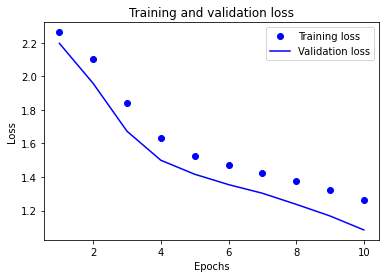

In [15]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

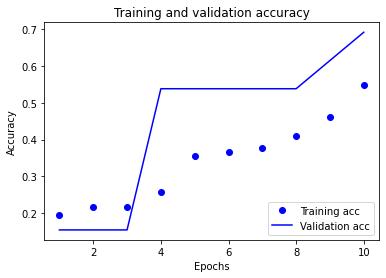

In [16]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [17]:
values = model.predict(unlabeled_ds)
classes = np.argmax(values, axis=1)

In [18]:
unlabeled_df['Cat'] = classes

<ipython-input-18-5e4f1cb0d31c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unlabeled_df['Cat'] = classes


In [19]:
unlabeled_df.head(10)

,Log,Cat
101,"T103 M20-1 5 minutes late, secondary delay fol...",2
102,"T373 released, 1 minute delay.",7
103,"Work orders issued Track 36 for the L13XL, vis...",2
104,"T377 K103 possible medical emergency, T/O inve...",2
105,65 trains/581 cars. PM Rush rated Excellent. 9...,2
106,"T377 ATO, now 6 minutes late.",7
107,"T371 C80-2 6 minutes late, blocked by OOS T771...",7
108,"T457 M80-2 BPD hold, welfare check, 6 minutes ...",2
109,"T377 C20-1 PSF 1 door out of the platform, con...",2
110,"T225 R60-1 BPD hold, welfare check.",2


In [20]:
# Save word embeddings 
# view embedding @ http://projector.tensorflow.org/
# upload vectors.tsv and metadata.tsv

weights = model.get_layer('embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()

save_embeddings(weights, vocab)

In [23]:
# :)